A straightforward approach to modeling this type of match outcome predictor is to use a **two-stream neural network** that separates team features into distinct inputs. Here’s a structured approach that tackles the input and model architecture for this problem:

### 1. **Input Representation**

Since there are two teams, we can separate the players’ information by team. Assuming you start with only the rank of each player, your input could look like this:

- **Team A**: [rank_1_A, rank_2_A, ..., rank_5_A]
- **Team B**: [rank_1_B, rank_2_B, ..., rank_5_B]

When you add more features (like accuracy, etc.), each player can have a feature vector with their attributes, such as `[rank, accuracy, kills, assists, etc.]`. The data input will then expand to:

- **Team A**: `[[rank_1_A, accuracy_1_A, ...], [rank_2_A, accuracy_2_A, ...], ..., [rank_5_A, accuracy_5_A, ...]]`
- **Team B**: `[[rank_1_B, accuracy_1_B, ...], [rank_2_B, accuracy_2_B, ...], ..., [rank_5_B, accuracy_5_B, ...]]`

In this way, each team’s data is organized distinctly.

### 2. **Neural Network Architecture**

A good starting point is a **two-stream neural network**, with one stream dedicated to each team. This setup allows each team’s information to be processed separately, which should help the model distinguish between Team A and Team B. Here’s how you could set up the architecture:

1. **Separate Team Embeddings**: For each team, create a subnetwork (stream) that processes the player data. You could use dense layers to embed and reduce each team’s feature representation.

    - **Team A Network**: Takes Team A’s features as input and outputs an embedded team feature vector.
    - **Team B Network**: Takes Team B’s features as input and outputs an embedded team feature vector.

2. **Combine Team Representations**: Once each team is processed through its respective network, concatenate the outputs from Team A and Team B’s networks to form a combined representation.

3. **Output Layer**: Pass the combined representation through a few dense layers and end with a binary output (e.g., sigmoid activation) to predict which team is more likely to win.

### 3. **Model Structure Example**

Here’s a simple pseudocode for implementing this model structure in Keras:

```python
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model

# Define input shapes
team_a_input = Input(shape=(5, num_features_per_player))  # Each player has a feature vector
team_b_input = Input(shape=(5, num_features_per_player))

# Team A processing stream
team_a_flattened = Flatten()(team_a_input)  # Flatten team inputs
team_a_dense = Dense(64, activation='relu')(team_a_flattened)
team_a_output = Dense(32, activation='relu')(team_a_dense)

# Team B processing stream
team_b_flattened = Flatten()(team_b_input)
team_b_dense = Dense(64, activation='relu')(team_b_flattened)
team_b_output = Dense(32, activation='relu')(team_b_dense)

# Combine team representations
combined = Concatenate()([team_a_output, team_b_output])
hidden = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(hidden)  # Binary output for team win/loss

# Model definition
model = Model(inputs=[team_a_input, team_b_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```

### 4. **Training Data and Labeling**

To train this model:

- **Input Data**: Each game should provide `[Team A features, Team B features]`.
- **Labels**: The output should be a binary label: `1` if Team A wins, and `0` if Team B wins.

### 5. **Expanding with Additional Data**

When you add new features like **accuracy, kills, deaths**, etc., you just increase the number of features per player. This architecture remains suitable, as each player’s features stay organized within each team’s input stream. 

### 6. **Further Improvements**

Once this simple model works, you could:

- **Normalize features** like ranks and accuracies to help stabilize training.
- **Experiment with deeper layers** or recurrent networks (RNNs or Transformers) if player interactions matter more intricately.
- **Add dropout** layers to help generalize and reduce overfitting, especially if you have limited data.

This setup should give you a solid starting model that can differentiate team features and handle individual player statistics effectively.

In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
all_match_file = Path("grouped_matchs.json")
with all_match_file.open() as f:
    all_matchs_raw = json.load(f)

print(f'Loaded {len(all_matchs_raw)} matchs')

Loaded 6772 matchs


In [3]:
all_matchs_raw[0]

{'metadata': {'map': 'Pearl',
  'game_version': 'release-09.08-shipping-7-2916535',
  'game_length': 2215,
  'game_start': 1730386891,
  'game_start_patched': 'Thursday, October 31, 2024 03:01 PM',
  'rounds_played': 21,
  'mode': 'Competitive',
  'mode_id': 'competitive',
  'queue': 'Standard',
  'season_id': 'dcde7346-4085-de4f-c463-2489ed47983b',
  'platform': 'pc',
  'matchid': '46a43e27-5e28-440f-af4c-bfd89bef9ac4',
  'premier_info': {'tournament_id': None, 'matchup_id': None},
  'region': 'eu',
  'cluster': 'London'},
 'players': {'all_players': [{'puuid': 'e81d6142-7d7c-5d1c-a517-7c3131a9af32',
    'name': 'supremeVDZGOAT',
    'tag': '7777',
    'team': 'Red',
    'level': 47,
    'character': 'Clove',
    'currenttier': 9,
    'currenttier_patched': 'Silver 1',
    'player_card': '4fe21607-4abb-ccd0-4e6f-718ff0e634f4',
    'player_title': 'd13e579c-435e-44d4-cec2-6eae5a3c5ed4',
    'party_id': 'b27eeb82-b516-4329-8f30-e4290f53a414',
    'session_playtime': {'minutes': 1611,
  

In [4]:
print(list(all_matchs_raw[0].keys()))
for key in all_matchs_raw[0].keys():
    print(key, [x for x in all_matchs_raw[0][key]])


['metadata', 'players', 'teams']
metadata ['map', 'game_version', 'game_length', 'game_start', 'game_start_patched', 'rounds_played', 'mode', 'mode_id', 'queue', 'season_id', 'platform', 'matchid', 'premier_info', 'region', 'cluster']
players ['all_players', 'red', 'blue']
teams ['red', 'blue']


In [5]:
simplified_matchs_dataframes = []

for match in all_matchs_raw:
    metadata = match['metadata']
    team_blue = match['players']['blue']
    team_red = match['players']['red']
    simplified_match = {
        'match_id': metadata['matchid'],
    }
    for i, player in enumerate(team_blue):
        simplified_match[f'blue_{i}_rank'] = player['currenttier_patched']
    
    for i, player in enumerate(team_red):
        simplified_match[f'red_{i}_rank'] = player['currenttier_patched']  
    
    simplified_match['winner'] = 'Blue' if match['teams']['blue']['has_won'] else 'Red'

    simplified_matchs_dataframes.append(simplified_match)

In [6]:
df = pd.DataFrame(simplified_matchs_dataframes)
df = df.drop_duplicates(subset="match_id")
print(f'Load {len(df)} matchs')
df.head()

Load 6113 matchs


,match_id,blue_0_rank,blue_1_rank,blue_2_rank,blue_3_rank,blue_4_rank,red_0_rank,red_1_rank,red_2_rank,red_3_rank,red_4_rank,winner
0,46a43e27-5e28-440f-af4c-bfd89bef9ac4,Bronze 3,Unrated,Bronze 1,Bronze 3,Silver 2,Silver 1,Bronze 1,Bronze 3,Bronze 3,Bronze 3,Red
1,724b1d1b-ac8a-4514-baad-4cc1b2c6e436,Bronze 3,Unrated,Silver 1,Silver 1,Bronze 2,Silver 2,Silver 2,Silver 1,Silver 1,Bronze 3,Blue
2,8b1cd838-d64b-4301-818a-ed68cb31aa03,Silver 1,Silver 1,Bronze 2,Bronze 2,Silver 1,Unrated,Bronze 2,Silver 2,Silver 2,Bronze 3,Blue
3,72883417-eaa4-4377-b99e-51dae66476d4,Gold 1,Silver 2,Silver 1,Silver 2,Silver 1,Bronze 3,Silver 3,Silver 2,Silver 2,Bronze 3,Red
4,ed37ab5e-b014-4afb-bb6b-01044d9203e0,Unrated,Silver 2,Silver 1,Bronze 2,Unrated,Silver 2,Gold 1,Bronze 2,Silver 1,Silver 1,Red


In [7]:
all_ranks_name = ['Unrated', 'Iron', 'Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Ascendant', 'Immortal', 'Radiant']
all_ranks =[all_ranks_name[0]] + [f'{rank} {i+1}' for rank in all_ranks_name[1:-1] for i in range(3)] + [all_ranks_name[-1]]
rank_to_number = { rank: i for i, rank in enumerate(all_ranks) }
number_to_rank = { i: rank for i, rank in enumerate(all_ranks) }

In [8]:
df['winner'] = df['winner'].apply(lambda x: 0 if x == 'Blue' else 1)
for i in range(5):
    df[f'blue_{i}_rank'] = df[f'blue_{i}_rank'].apply(lambda x: rank_to_number[x])
    df[f'red_{i}_rank'] = df[f'red_{i}_rank'].apply(lambda x: rank_to_number[x])

df.head()

,match_id,blue_0_rank,blue_1_rank,blue_2_rank,blue_3_rank,blue_4_rank,red_0_rank,red_1_rank,red_2_rank,red_3_rank,red_4_rank,winner
0,46a43e27-5e28-440f-af4c-bfd89bef9ac4,6,0,4,6,8,7,4,6,6,6,1
1,724b1d1b-ac8a-4514-baad-4cc1b2c6e436,6,0,7,7,5,8,8,7,7,6,0
2,8b1cd838-d64b-4301-818a-ed68cb31aa03,7,7,5,5,7,0,5,8,8,6,0
3,72883417-eaa4-4377-b99e-51dae66476d4,10,8,7,8,7,6,9,8,8,6,1
4,ed37ab5e-b014-4afb-bb6b-01044d9203e0,0,8,7,5,0,8,10,5,7,7,1


In [9]:
# mean rank of the entire dataset
mean_rank_number = df.loc[:, ['blue_0_rank', 'blue_1_rank', 'blue_2_rank', 'blue_3_rank', 'blue_4_rank', 'red_0_rank', 'red_1_rank', 'red_2_rank', 'red_3_rank', 'red_4_rank']].mean().mean()
std_rank_number = df.loc[:, ['blue_0_rank', 'blue_1_rank', 'blue_2_rank', 'blue_3_rank', 'blue_4_rank', 'red_0_rank', 'red_1_rank', 'red_2_rank', 'red_3_rank', 'red_4_rank']].std().mean()
print(f'Mean rank of the entire dataset: {number_to_rank[int(mean_rank_number)]}')
print(f'Std rank of the entire dataset: {number_to_rank[int(mean_rank_number - std_rank_number)]} to {number_to_rank[int(mean_rank_number + std_rank_number)]}')
print('Careful, those values are for reference only, the unrated rank break the scale')

Mean rank of the entire dataset: Silver 3
Std rank of the entire dataset: Iron 3 to Platinum 2
Careful, those values are for reference only, the unrated rank break the scale


In [10]:
number_to_rank

{0: 'Unrated',
 1: 'Iron 1',
 2: 'Iron 2',
 3: 'Iron 3',
 4: 'Bronze 1',
 5: 'Bronze 2',
 6: 'Bronze 3',
 7: 'Silver 1',
 8: 'Silver 2',
 9: 'Silver 3',
 10: 'Gold 1',
 11: 'Gold 2',
 12: 'Gold 3',
 13: 'Platinum 1',
 14: 'Platinum 2',
 15: 'Platinum 3',
 16: 'Diamond 1',
 17: 'Diamond 2',
 18: 'Diamond 3',
 19: 'Ascendant 1',
 20: 'Ascendant 2',
 21: 'Ascendant 3',
 22: 'Immortal 1',
 23: 'Immortal 2',
 24: 'Immortal 3',
 25: 'Radiant'}

In [11]:
# df = df.drop(columns='match_id')
# df.to_csv('raw_data.csv')

In [12]:
import torch

X = torch.tensor(df.loc[:, ['blue_0_rank', 'blue_1_rank', 'blue_2_rank', 'blue_3_rank', 'blue_4_rank', 'red_0_rank', 'red_1_rank', 'red_2_rank', 'red_3_rank', 'red_4_rank']].values, dtype=torch.long)
y = torch.tensor(df['winner'].values, dtype=torch.long)

print(X.shape, y.shape)

n = int(0.9*len(y)) # first 90% will be train, rest val
X_train_data = X[:n]
X_val_data = X[n:]
Y_train_data = y[:n]
Y_val_data = y[n:]
print(X_train_data.shape, X_val_data.shape)

KeyboardInterrupt: 

In [35]:
batch_size = 32

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = X_train_data if split == 'train' else X_val_data
    label = Y_train_data if split == 'train' else Y_val_data
    ix = torch.randint(len(data), (batch_size,))
    x = torch.stack([data[i] for i in ix])
    y = torch.stack([label[i] for i in ix])
    return x, y

In [36]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb[:5])
print('targets:')
print(yb.shape)
print(yb[:5])

print('----')

for b in range(batch_size): # batch dimension
    inp = xb[b]
    target = yb[b]
    print(f'When input is {inp} the target: {target}')

inputs:
torch.Size([32, 10])
tensor([[ 4,  5,  3,  4,  4,  4,  3,  3,  4,  4],
        [ 8,  8,  0,  7,  9,  8,  8,  6,  9,  6],
        [ 9,  9,  8,  4,  7,  7,  7, 11,  9,  6],
        [22, 22, 24, 22, 24, 23, 22, 23, 24, 22],
        [ 0,  8,  7,  0,  0,  8,  9,  7,  0,  7]])
targets:
torch.Size([32])
tensor([0, 0, 1, 1, 1])
----
When input is tensor([4, 5, 3, 4, 4, 4, 3, 3, 4, 4]) the target: 0
When input is tensor([8, 8, 0, 7, 9, 8, 8, 6, 9, 6]) the target: 0
When input is tensor([ 9,  9,  8,  4,  7,  7,  7, 11,  9,  6]) the target: 1
When input is tensor([22, 22, 24, 22, 24, 23, 22, 23, 24, 22]) the target: 1
When input is tensor([0, 8, 7, 0, 0, 8, 9, 7, 0, 7]) the target: 1
When input is tensor([4, 0, 0, 5, 3, 3, 3, 4, 0, 3]) the target: 0
When input is tensor([11, 12, 11, 12, 12, 10, 13, 13, 10, 12]) the target: 0
When input is tensor([11,  6, 11, 12, 11,  8,  5,  9, 16, 11]) the target: 0
When input is tensor([9, 8, 3, 8, 4, 7, 6, 5, 9, 7]) the target: 1
When input is tensor([

In [37]:
import torch
import torch.nn as nn
from torch.nn import functional as F

n_embd = 16
n_layer = 5
dropout = 0.1
# win_weight = df.count # ratio between win and loss for the binary cross entropy loss

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(n_embd),
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return x + self.net(x) # residual connection

class ValorantOucomesMatchModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.rank_embedding_table = nn.Embedding(len(number_to_rank),n_embd)
        self.blocks = nn.Sequential(*[FeedFoward(n_embd) for _ in range(n_layer)])
        self.ln_f1 = nn.LayerNorm(n_embd) 
        self.ln_f2 = nn.LayerNorm(n_embd) 
        self.lm_head = nn.Linear(n_embd, 2) # 2 outcomes 
    
    def forward(self, idx, targets = None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        x = self.rank_embedding_table(idx) # (B,T,C)
        x = torch.mean(self.ln_f1(x),dim=1)
        x = self.blocks(x) # (B,C)
        x = self.ln_f2(x) # (B,C)
        logits = self.lm_head(x) # (B,2)

        if targets is None:
            loss = None
        else:
            B, C = logits.shape
            loss = F.cross_entropy(logits, targets)

        return logits, loss

In [38]:
learning_rate = 1e-3
max_iters = 5000
eval_interval = 100
eval_iters = 200

In [39]:
model = ValorantOucomesMatchModel()
print(sum(p.numel() for p in model.parameters()), 'parameters')

11314 parameters


In [40]:
model.blocks[0].net

Sequential(
  (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=16, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=16, bias=True)
  (4): Dropout(p=0.1, inplace=False)
)

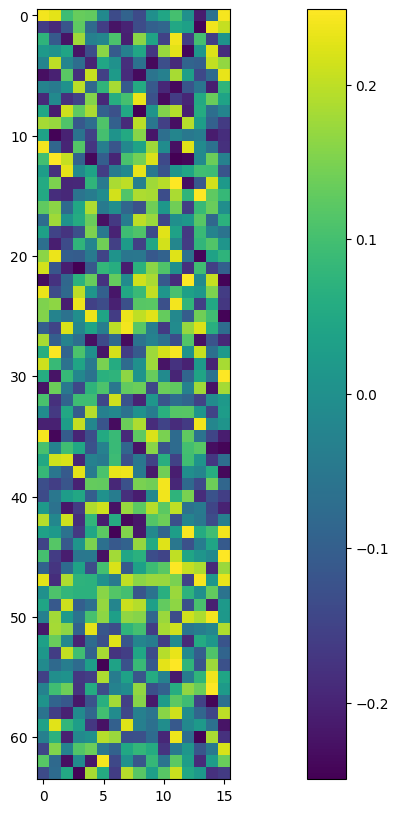

In [41]:
torch.tensor(model.blocks[0].net[1].weight.tolist()).shape

plt.figure(figsize=(20,10))
plt.imshow(torch.tensor(model.blocks[0].net[1].weight.tolist()))
plt.colorbar()

In [42]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [43]:
estimate_loss()

{'train': tensor(0.7992), 'val': tensor(0.7728)}

In [44]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 0.7963, val loss 0.7848
step 100: train loss 0.7043, val loss 0.7068
step 200: train loss 0.6961, val loss 0.7063
step 300: train loss 0.6919, val loss 0.7000
step 400: train loss 0.6906, val loss 0.7003
step 500: train loss 0.6910, val loss 0.6962
step 600: train loss 0.6915, val loss 0.6958
step 700: train loss 0.6906, val loss 0.6980
step 800: train loss 0.6905, val loss 0.6959
step 900: train loss 0.6926, val loss 0.7010
step 1000: train loss 0.6924, val loss 0.7008
step 1100: train loss 0.6876, val loss 0.6963
step 1200: train loss 0.6894, val loss 0.6962
step 1300: train loss 0.6895, val loss 0.7038
step 1400: train loss 0.6897, val loss 0.6991
step 1500: train loss 0.6890, val loss 0.6957
step 1600: train loss 0.6897, val loss 0.7031
step 1700: train loss 0.6858, val loss 0.6980
step 1800: train loss 0.6876, val loss 0.6948
step 1900: train loss 0.6872, val loss 0.6971
step 2000: train loss 0.6858, val loss 0.7064
step 2100: train loss 0.6885, val loss 0.7051


for a team composed of [14, 14, 0, 0, 14, 13, 12, 15, 14, 14], we get the probabilities tensor([0.4198, 0.5802]) and the winner was 1
for a team composed of [14, 15, 14, 14, 14, 14, 16, 15, 14, 14], we get the probabilities tensor([0.4978, 0.5022]) and the winner was 1
for a team composed of [0, 13, 11, 10, 14, 12, 13, 15, 15, 11], we get the probabilities tensor([0.5716, 0.4284]) and the winner was 1
for a team composed of [10, 12, 12, 11, 11, 9, 13, 12, 10, 11], we get the probabilities tensor([0.5385, 0.4615]) and the winner was 1
for a team composed of [13, 11, 12, 13, 11, 10, 15, 10, 14, 11], we get the probabilities tensor([0.5133, 0.4867]) and the winner was 0
for a team composed of [1, 7, 4, 4, 7, 3, 5, 5, 7, 5], we get the probabilities tensor([0.2398, 0.7602]) and the winner was 0
for a team composed of [3, 4, 6, 5, 4, 3, 3, 3, 5, 3], we get the probabilities tensor([0.5046, 0.4954]) and the winner was 0
for a team composed of [22, 24, 24, 23, 24, 24, 24, 23, 22, 24], we get 

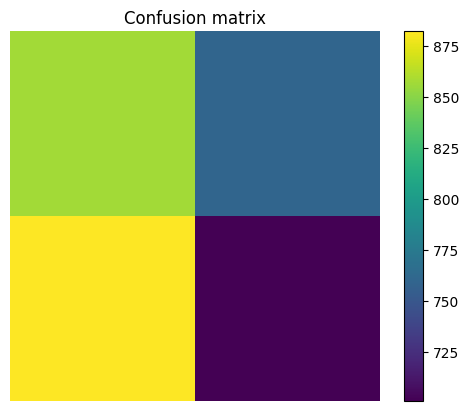

tensor([[857., 760.],
        [882., 701.]])


In [ ]:
# confusion matrix
conf_matrix = torch.zeros(2, 2)
eval_iters = 100
with torch.no_grad():
    model.eval()
    for k in range(eval_iters):
        X, Y = get_batch('val')
        logits, _ = model(X, Y)
        probs = F.softmax(logits, dim=-1)
        print(f'for a team composed of {X[0].tolist()}, we get the probabilities {probs[0]} and the winner was {Y[0]}')
        for t, p in zip(Y.view(-1), probs.argmax(1)):
            conf_matrix[t.long(), p.long()] += 1
    model.train()
        

plt.imshow(conf_matrix, interpolation='nearest')
plt.colorbar()
plt.title('Confusion matrix')
plt.axis('off')
plt.show()
print(conf_matrix)

In [12]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda


class ValorantDataSet(Dataset):
	# here you can manipulate the imported data to fit special format, normalize and other manipulation
	# the transfrom and target_transform are methods you want to apply to the data further in the process
	def __init__(self, data, transform=None, target_transform=None):
		# we equilibrate the dataset by taking the minimum number of elements in the dataset
		self.data = data
		self.transform = transform # for the features
		self.target_transform = target_transform # for the labels

	# to calculate the size of all the data
	def __len__(self):
		return len(self.data)

	# access the data
	def __getitem__(self, idx):
		element = self.data.iloc[idx]
		value = element.drop(['winner','match_id']).values
		label = element['winner']
		if self.transform:
			value = value.astype('float')
			value = self.transform(value)
		if self.target_transform:
			label = label.astype('int')
			label = self.target_transform(label)
		return value, label

In [13]:
train_dataset = df.sample(frac=0.8, random_state=0)
val_dataset = df.drop(train_dataset.index)
test_dataset = val_dataset.sample(frac=0.5, random_state=0)

print(f"Training data shape: {train_dataset.shape}")
print(f"Validation data shape: {val_dataset.shape}")
print(f"Testing data shape: {test_dataset.shape}")

feature_transform = Lambda(lambda list : torch.tensor(list,dtype=torch.float32))
label_transform = Lambda(lambda y: torch.zeros(2, dtype=torch.float32).scatter_(0, torch.tensor(y), value=1.0))

# the batch size is the number of elements we want to process at once
# like that we dont learn from one element at a time
train_loader = DataLoader(ValorantDataSet(train_dataset, 
                                            transform=feature_transform,
                                            target_transform=label_transform),
                                            batch_size=32, shuffle=True)
validation_loader = DataLoader(ValorantDataSet(val_dataset,
                                                transform=feature_transform,
                                                target_transform=label_transform),
                                                batch_size=32, shuffle=False)
test_loader = DataLoader(ValorantDataSet(test_dataset,
                                        transform=feature_transform,
                                        target_transform=label_transform),
                                        batch_size=32, shuffle=False)

# you can then iterate througt the data with iter() and next()
data_iter = iter(train_loader)
# team_rank contains an entire batch ans so does labels -> 64 elements
team_rank, winner = next(data_iter)

Training data shape: (4890, 12)
Validation data shape: (1223, 12)
Testing data shape: (612, 12)


In [14]:
class Two_stream_Net(torch.nn.Module):
    def __init__(self):
        super(Two_stream_Net, self).__init__()
        self.fc1 = torch.nn.Linear(10, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 2)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [16]:
model = Two_stream_Net()
# Hyperparameters
learning_rate = 0.01
epochs = 100
batch_size = 64
# how to tell the model how good it is ( or bad )
loss_function = torch.nn.MSELoss()
# how to backpropagate the error and update the weights in the network
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [18]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # print(f"pred: {pred.argmax(1)}")
            # print(f"y: {y.argmax(1)}")
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return test_loss, correct

Epochs: 100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


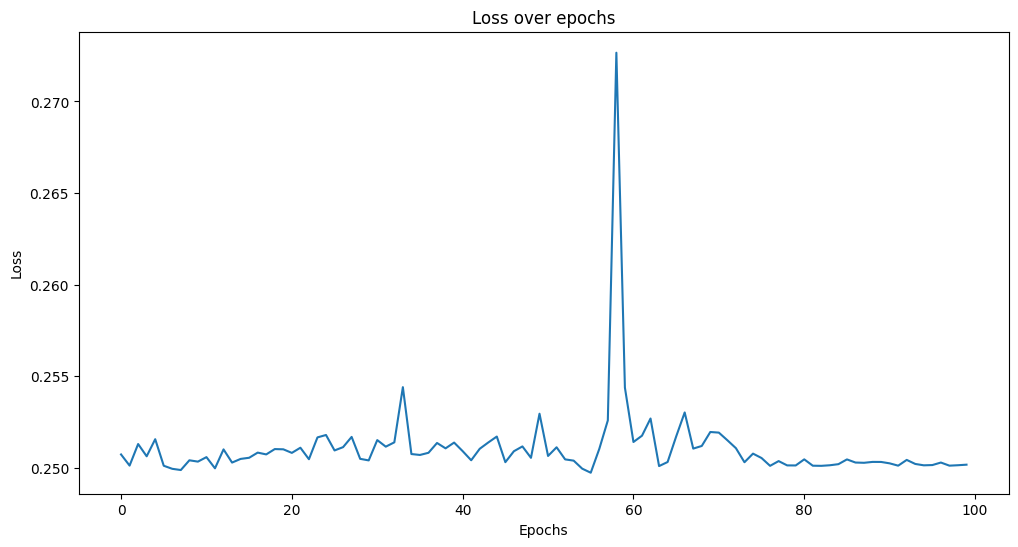

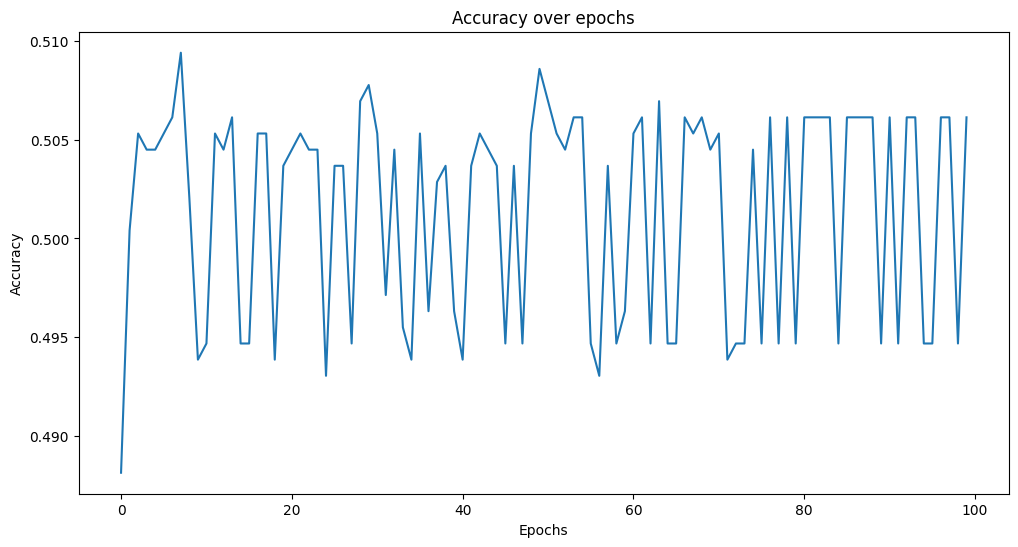

In [19]:
lost_list = []
correct_list = []
for t in tqdm(range(epochs), desc="Epochs"):
    train_loop(train_loader, model, loss_function, optimizer)
    test_loss, correct = test_loop(validation_loader, model, loss_function)
    lost_list.append(test_loss)
    correct_list.append(correct)
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

plt.figure(figsize=(12, 6))
plt.plot(lost_list)
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(correct_list)
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [20]:
test_loss, correct = test_loop(test_loader, model, loss_function)
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 48.4%, Avg loss: 0.250516 



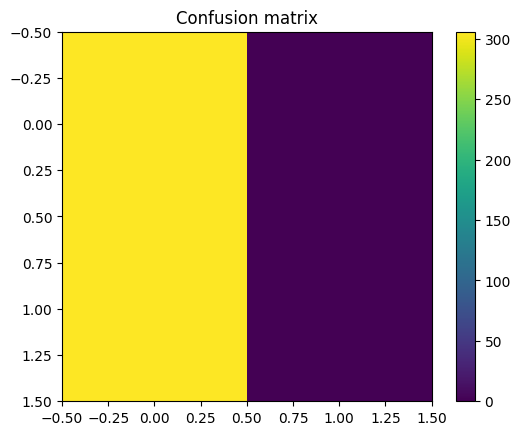

In [21]:
# confusion matrix
conf_matrix = torch.zeros(2, 2)
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X)
        for t, p in zip(y.view(-1), pred.argmax(1)):
            conf_matrix[t.long(), p.long()] += 1

plt.imshow(conf_matrix, interpolation='nearest')
plt.colorbar()
plt.title('Confusion matrix')
plt.show()

In [13]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
all_match_file = Path("grouped_matchs.json")
with all_match_file.open() as f:
    all_matchs_raw = json.load(f)

print(f'Loaded {len(all_matchs_raw)} matchs')

Loaded 6772 matchs


In [39]:
def get_individual_player_stats(dict:dict, player_idx, team_idx) -> list:
    stats = {}
    suffix = f'_{team_idx}_{player_idx}'
    # rank
    stats[f'rank{suffix}'] = dict['currenttier']
    # combat score
    for k, v in dict['stats'].items():
        stats[f'{k}{suffix}'] = v
    # damage count
    stats[f'damage_made{suffix}'] = dict['damage_made']
    stats[f'damage_received{suffix}'] = dict['damage_received']
    return stats
    

simplified_matchs_dataframes = []

for match in all_matchs_raw:
    metadata = match['metadata']
    team_blue = match['players']['blue']
    team_red = match['players']['red']
    simplified_match = {
        'match_id': metadata['matchid'],
    }
    for i, player in enumerate(team_blue):
        simplified_match.update(get_individual_player_stats(player,i,0))
    
    for i, player in enumerate(team_red):
        simplified_match.update(get_individual_player_stats(player,i,1))
    
    simplified_match['winner'] = 0 if match['teams']['blue']['has_won'] else 1

    simplified_matchs_dataframes.append(simplified_match)

In [40]:
df_enhance = pd.DataFrame(simplified_matchs_dataframes)
df_enhance = df_enhance.drop_duplicates(subset="match_id")
df_enhance = df_enhance.drop(columns='match_id')
print(len(df_enhance))
df_enhance

6113


,rank_0_0,score_0_0,kills_0_0,deaths_0_0,assists_0_0,bodyshots_0_0,headshots_0_0,legshots_0_0,damage_made_0_0,damage_received_0_0,...,score_1_4,kills_1_4,deaths_1_4,assists_1_4,bodyshots_1_4,headshots_1_4,legshots_1_4,damage_made_1_4,damage_received_1_4,winner
0,8,2897,8,19,5,47,4,3,2024,3551,...,5468,20,13,7,45,15,4,4000,2700,1
1,8,4318,13,16,6,63,9,8,3035,3004,...,2115,6,18,6,25,6,1,1717,3519,0
2,9,6170,22,10,5,57,12,8,4282,2486,...,7415,28,18,2,54,21,1,4897,3251,0
3,12,3449,10,14,2,52,5,9,2003,2669,...,5388,20,6,6,55,14,10,3196,1675,1
4,0,7400,25,22,2,49,20,4,4668,4048,...,5041,18,22,8,57,12,2,3085,4101,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6767,12,4611,12,19,9,59,10,4,3402,3483,...,5260,19,20,12,34,13,1,3344,3742,0
6768,15,4938,18,8,7,49,12,13,3285,1654,...,4396,15,14,4,24,12,1,2760,2356,0
6769,15,3301,10,11,14,42,10,2,2248,1861,...,3246,10,16,2,20,9,2,2183,3050,0
6770,0,2859,11,14,2,24,6,3,1719,2926,...,3517,13,7,3,34,6,1,2232,1696,1


In [41]:
df_enhance.to_csv('raw_data_enhance.csv')